In [141]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Based on Jäckel (2015)
from py_vollib.black_scholes import black_scholes
from py_vollib.black import black

### Import and Preprocess Data

In [ ]:
with open("mapping and calibration/files/calibrated_chunks_hagan.pkl", "rb") as f:
    chunks_hagan = pickle.load(f)
with open("mapping and calibration/files/calibrated_chunks_antonov.pkl", "rb") as f:
    chunks_antonov = pickle.load(f)
with open("mapping and calibration/files/calibrated_chunks_nn.pkl", "rb") as f:
    chunks_nn = pickle.load(f)

In [143]:
# Combine chunks
chunks = []
for df1, df2, df3 in zip(chunks_hagan, chunks_antonov, chunks_nn):
    combined_df = pd.concat([df1, df2, df3], axis=1)
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
    chunks.append(combined_df)

### Compute Arbitrage Violations

In [144]:
# Add Black model call prices using py_vollib
for method in ["nn", "hagan", "antonov"]:
    for i, chunk in enumerate(chunks):
        chunk = chunk.copy()
        chunk[f"call_price_{method}"] = chunk.apply(
            lambda row: black(
                F=float(row["forward_price"]),
                K=float(row["strike_price"]),
                sigma=float(row[f"impl_volatility_{method}"]),
                flag="c",
                r=0.0,
                t=float(row["T"]),
            ),
            axis=1
        )
        chunks[i] = chunk

### Butterfly Spread

In [145]:
# Check for violations of butterfly spread condition
def add_convexity_violation_column(chunks, column_name, tol=0.00):
    updated_chunks = []

    for chunk in chunks:
        K = chunk["strike_price"].values
        C = chunk[f"{column_name}"].values
        f = chunk["forward_price"].values

        violation_flags = np.zeros(len(chunk), dtype=bool)

        # All strikes have the same distance between them
        for i in range(1, len(C) - 1):
            d1 = (C[i] - C[i - 1]) 
            d2 = (C[i + 1] - C[i]) + (tol*C[i])
            if d2 <= d1:
                violation_flags[i] = True

        if ((C[0] - f[0]) / (K[0] - 0)) >= ((C[1] - C[0] + (tol*C[0])) / (K[1] - K[0])):
            violation_flags[0] = True
        
        chunk[f"{column_name}_butterfly_violation"] = violation_flags
        updated_chunks.append(chunk)

    return updated_chunks

for column_name in ["call_price_nn", "call_price_hagan", "call_price_antonov"]:
    chunks = add_convexity_violation_column(chunks, column_name)


### Positivity

In [146]:
# Check for violations of positivity condition
def add_positivity_violation_column(chunks, column_name):
    updated_chunks = []

    for chunk in chunks:
        C = chunk[f"{column_name}"].values

        violation_flags = np.zeros(len(chunk), dtype=bool)

        for i in range(0, len(C) - 1):
            if C[i] < 0:
                violation_flags[i] = True
        
        chunk[f"{column_name}_positivity_violation"] = violation_flags
        updated_chunks.append(chunk)

    return updated_chunks

for column_name in ["call_price_nn", "call_price_hagan", "call_price_antonov"]:
    chunks = add_positivity_violation_column(chunks, column_name)


### Vertical Spread

In [147]:
# Check for violations of vertical spread condition
def add_strike_violation_column(chunks, column_name, tol=0.00):
    updated_chunks = []

    for chunk in chunks:

        C = chunk[f"{column_name}"].values

        violation_flags = np.zeros(len(chunk), dtype=bool)

        for i in range(1, len(C)):
            if C[i] >= C[i-1] + (tol*C[i-1]):
                violation_flags[i] = True
        
        chunk[f"{column_name}_vertical_violation"] = violation_flags
        updated_chunks.append(chunk)

    return updated_chunks

for column_name in ["call_price_nn", "call_price_hagan", "call_price_antonov"]:
    chunks = add_strike_violation_column(chunks, column_name)


In [148]:
df = pd.concat(chunks, ignore_index=True)

In [149]:
print(f"positivity nn: {len(df[df['call_price_nn_positivity_violation'] == True]) / len(df) * 100}")
print(f"positivity hagan: {len(df[df['call_price_hagan_positivity_violation'] == True]) / len(df) * 100}")
print(f"positivity antonov: {len(df[df['call_price_antonov_positivity_violation'] == True]) / len(df) * 100}")

positivity nn: 0.0
positivity hagan: 0.0
positivity antonov: 0.0


In [150]:
print(f"vertical nn: {len(df[df['call_price_nn_vertical_violation'] == True]) / len(df) * 100}")
print(f"vertical hagan: {len(df[df['call_price_hagan_vertical_violation'] == True]) / len(df) * 100}")
print(f"vertical antonov: {len(df[df['call_price_antonov_vertical_violation'] == True]) / len(df) * 100}")

vertical nn: 0.12056014096262636
vertical hagan: 0.04018671365420878
vertical antonov: 0.08037342730841757


In [151]:
# removing last strike as it cannot have an arbitrage violation
chunks_no_last_strike = [chunk[:-1] for chunk in chunks] 
df2 = pd.concat(chunks_no_last_strike, ignore_index=True)

In [152]:
print(f"butterfly nn: {len(df2[df2['call_price_nn_butterfly_violation'] == True]) / len(df2) * 100}")
print(f"butterfly hagan: {len(df2[df2['call_price_hagan_butterfly_violation'] == True]) / len(df2) * 100}")
print(f"butterfly antonov: {len(df2[df2['call_price_antonov_butterfly_violation'] == True]) / len(df2) * 100}")

butterfly nn: 2.8102969791699897
butterfly hagan: 0.7049666656033685
butterfly antonov: 0.5614214169510989


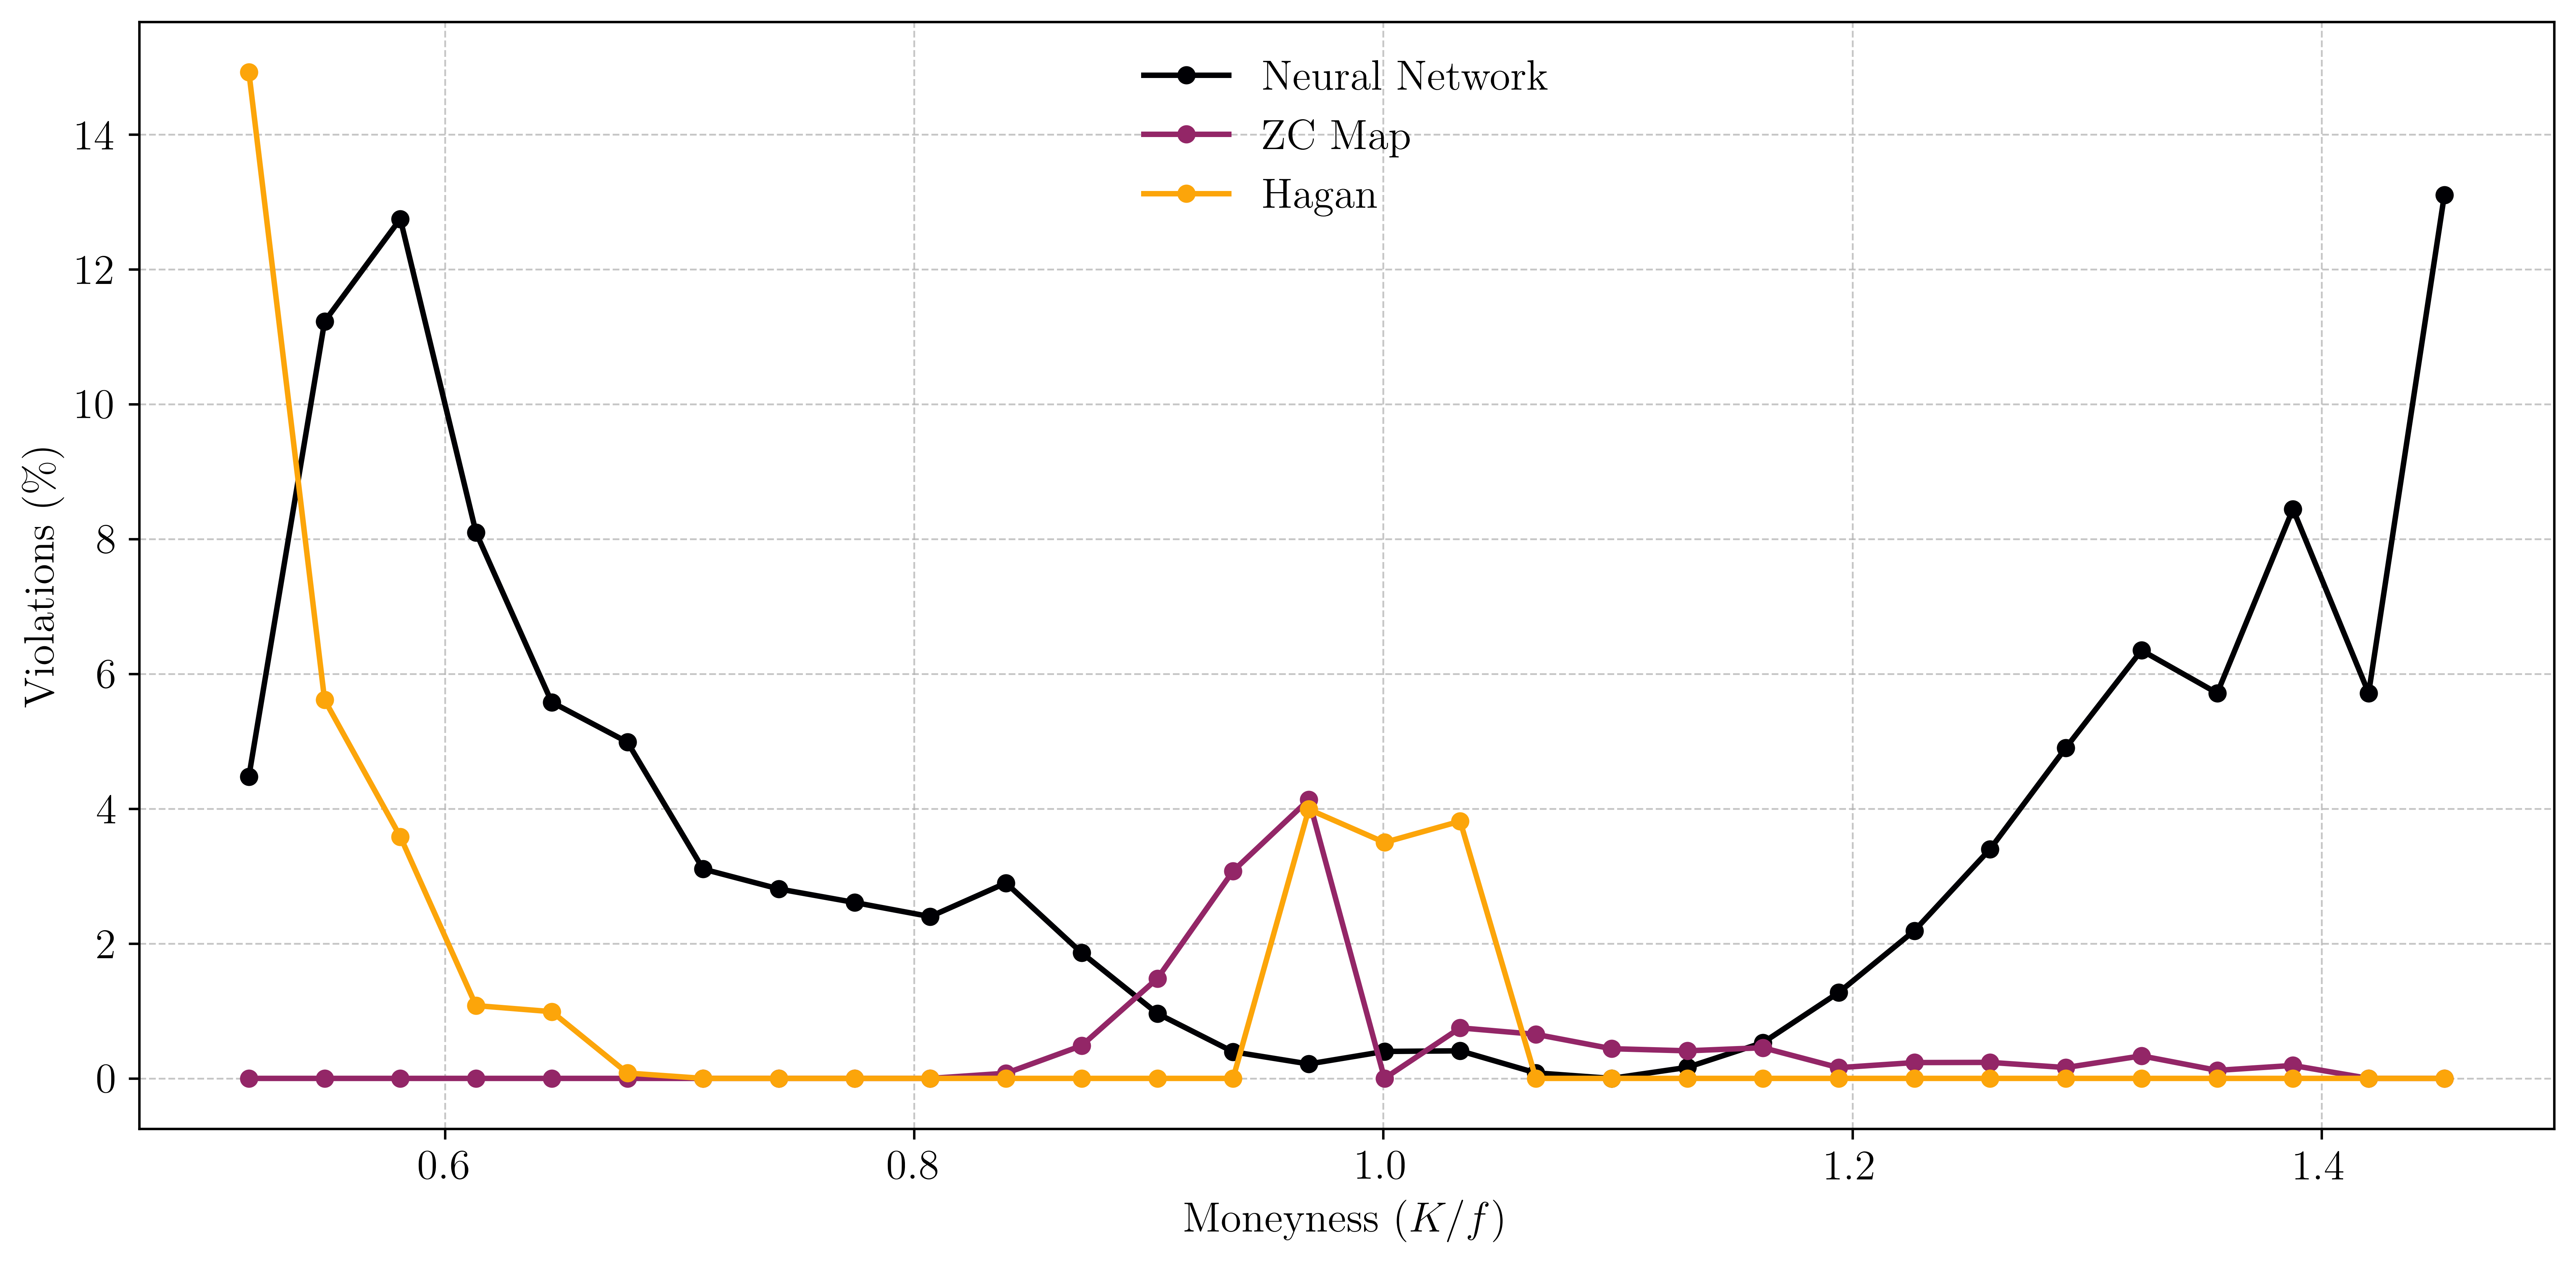

In [153]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'text.usetex': True,
})

df2["moneyness"] = df2["strike_price"] / df2["forward_price"]
methods = ["call_price_nn", "call_price_hagan", "call_price_antonov"]

moneyness = df2["moneyness"]
bins = 30
bin_edges = np.linspace(moneyness.min(), moneyness.max(), bins + 1)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

counts = pd.DataFrame({"moneyness_bin": bin_centers})
bin_labels = pd.cut(moneyness, bins=bin_edges)
total_counts = bin_labels.value_counts().sort_index().values

for method in methods:
    violations = df2.loc[df2[f"{method}_butterfly_violation"], "moneyness"]
    violation_counts = pd.cut(violations, bins=bin_edges).value_counts().sort_index().values
    counts[f"{method}_violations_pct"] = (
        np.divide(violation_counts, total_counts,
                  out=np.zeros_like(violation_counts, dtype=float),
                  where=total_counts != 0) * 100
    )

base_cmap = plt.cm.inferno
truncated_cmap = base_cmap(np.linspace(0, 0.8, 3))

plt.figure(figsize=(12, 6), dpi=600)

plt.plot(counts["moneyness_bin"], counts["call_price_nn_violations_pct"],
         label=r'Neural Network',
         color=truncated_cmap[0],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(counts["moneyness_bin"], counts["call_price_antonov_violations_pct"],
         label=r'ZC Map',
         color=truncated_cmap[1],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(counts["moneyness_bin"], counts["call_price_hagan_violations_pct"],
         label=r'Hagan',
         color=truncated_cmap[2],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)


plt.xlabel(r'Moneyness ($K/f$)')
plt.ylabel(r'Violations (\%)')

plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()